# **Ejercicio 3.3**

En el notebook https://github.com/manlio99/Materia-de-aprendizaje/blob/master/3_MidtermProjects/musica.ipynb hay un dataset con 2000+ canciones de Spotify de una usuaria, donde algunas fueron marcadas como gustadas y otras no. Cada canción tiene a su vez 16 atributos (nombre, artista, duración, bailable, etc.). 

Desarrollar un clasificador que prediga si una canción dada va a ser gustada  no. Aclarar y justificar los pasos, analizar y explicar los resultados.

In [49]:
# Usaremos las siguientes bibliotecas
# Datos
import numpy as np 
import pandas as pd 

# Viz
import seaborn as sns
import matplotlib.pyplot as plt

## **Leer dataset**

In [50]:
attributes_spotify = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBOM/data/attributes_spotify.csv")
attributes_spotify.describe()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,1008.000000,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,582.402066,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000000,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,504.000000,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,1008.000000,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,1512.000000,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,2016.000000,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


Este dataset está compuesto por canciones de 2017 con atributos de la API de Spotify. Cada canción ha sido etiquetada por "1" cuando al usuario le gusta la canción o "0" si no le gusta.

Cada fila del dataframe representa una canción. Hay 16 columnas, 13 de las cuales son atributos de la canción, una columna para el nombre de la canción, una para el artista y una columna llamada "destino", que es la etiqueta mencionada anteriormente para la canción. Los atributos de la pista son: acústica, bailabilidad, duración, energía, instrumentalidad, clave, vivacidad, volumen, modo, habla, tempo, marca de tiempo, valencia y target

In [51]:
attributes_spotify.head()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


## **Selección de atributos**

El primer atributo Unnamed parece ser simplemente el índice de los registros.. Chequeo por las dudas con un histograma.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


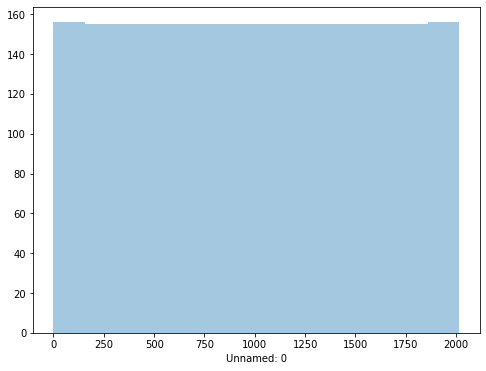

In [52]:
plt.figure(figsize=(8,6))
sns.distplot(attributes_spotify['Unnamed: 0'], kde=False)

El histograma confirma lo anterior, entonces lo saco de mi dataset

In [53]:
attributes_spotify_preparation = attributes_spotify.drop(columns=['Unnamed: 0'])
attributes_spotify_preparation.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


El atributo song_title tampoco considero que deba influir en si una canción es gustada o no. Pienso que puede llegar a ocurrir que ciertas palabras en el título de una canción llamen más la atención a cierto usuario, por lo que puede llegar a tener influencia en si una canción es escuchada o no. Pero de ahí a que influya en si le gusta o no, me parece arbitrario. Por lo que elijo sacar este atributo.

Pero antes me gustaría ver si hay algún título que se repite. Me imagino por ejemplo la misma canción versionada por distintos artistas. En este caso puede ocurrir que siempre sea gustada sin importar quién la versione. Para eso me fijo si hay algún título que se repita más de 2 veces.

In [54]:
i = 0
for song in attributes_spotify_preparation['song_title']:
  k = 1
  for song2 in attributes_spotify_preparation['song_title'][i+1:]:
    if (song2==song):
      k += 1
  if k>2:
    print(k,song)
  if k>3:
    print(k,song)    
  i += 1

3 River
3 Jack


Vemos que los títulos 'River' y 'Jack' se repiten sólo 3 veces. Pero no tengo ningún atributo que me pueda llegar a decir si representan la misma canción en diferentes versiones. Además que son nombres muy comunes, por lo tanto descarto la posibilidad que pensé antes y saco el atributo song_title.

In [55]:
attributes_spotify_preparation = attributes_spotify_preparation.drop(columns=['song_title'])
attributes_spotify_preparation.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Junior Boys


Para el atributo 'artist' me interesaría ver si hay artistas que siempre sean gustados. Eso le puede llegar a dar cierta relevancia al atributo. En ese caso, el problema va a ser cuantificarlo. De todas formas, como voy a utilizar el clasificador de k-vecinos más cercanos, no voy a considerar este atributo porque considero que no tiene sentido medir distancias a el nombre de un artista. Por ejemplo, si el artista 'Future' aparece 100 veces y es gustado las 100, otro artista llamado 'Futuristic' puede llegar a ser predecido como gustado cuando no tiene nada que ver. Esto considerando que la cuantificación sea por orden alfabético. Como por el momento no se me ocurre otra forma de cuantificarlo, y teniendo en cuenta que no debe haber casos de artistas con muchas canciones dentro del dataset como para tener una estadística significante, descarto este atributo.

In [56]:
attributes_spotify_preparation = attributes_spotify_preparation.drop(columns=['artist'])
attributes_spotify_preparation.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1


Vamos a realizar los histogramas de los atributos 'key', 'mode' y 'time_signature' porque me llaman la atención sus valores.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

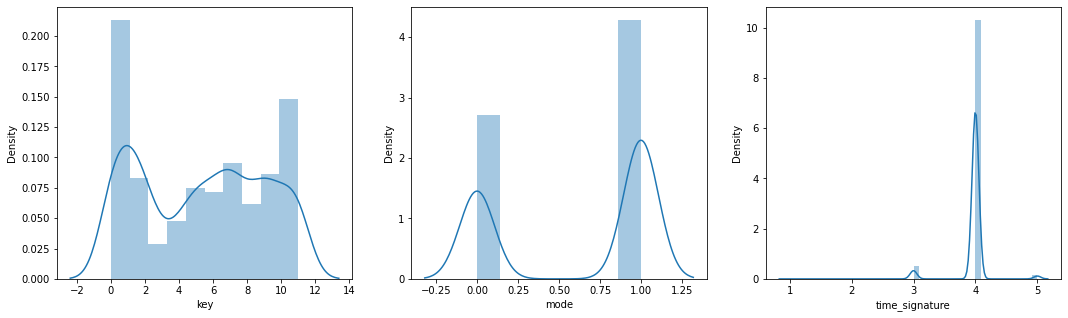

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
# fit=norm , kde=False, bins=20
sns.distplot(attributes_spotify_preparation["key"], ax=axes[0])
sns.distplot(attributes_spotify_preparation["mode"], ax=axes[1])
sns.distplot(attributes_spotify_preparation["time_signature"], ax=axes[2])

El atributo 'key' presenta valores enteros sin una distribución paramétrica conocida. Además que de alguna forma me está diciendo la nota principal en que está escrita la canción. Por estos motivos no la considereo relevante. El atributo 'mode' me arroja valores binarios: 1 representando si la modalidad de la melodía es mayor y 0 si es menor. Considero este atributo como no relevante teniendo en cuenta además que las distancias me darán 0 o 1 para este atributo solamente. El atributo 'time_signature' vemos que toma valores enteros solamente con una gran predominancia del valor 4, por lo que puede llegar a ser una variable perjudicial dado que ni siquiera sirve estandarizarla por tener desviación standard menor que 1, entonces la descarto también.

In [58]:
attributes_spotify_preparation = attributes_spotify_preparation.drop(columns=['key','mode','time_signature'])
attributes_spotify_preparation.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,target
0,0.0102,0.833,204600,0.434,0.021900,0.1650,-8.795,0.4310,150.062,0.286,1
1,0.1990,0.743,326933,0.359,0.006110,0.1370,-10.401,0.0794,160.083,0.588,1
2,0.0344,0.838,185707,0.412,0.000234,0.1590,-7.148,0.2890,75.044,0.173,1
3,0.6040,0.494,199413,0.338,0.510000,0.0922,-15.236,0.0261,86.468,0.230,1
4,0.1800,0.678,392893,0.561,0.512000,0.4390,-11.648,0.0694,174.004,0.904,1


Finalmente elijo quedarme con estos atributos que considero relevantes.

In [59]:
attributes_spotify_preparation.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,target
count,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,0.187590,0.618422,2.463062e+05,0.681577,0.133286,0.190844,-7.085624,0.092664,121.603272,0.496815,0.505702
std,0.259989,0.161029,8.198181e+04,0.210273,0.273162,0.155453,3.761684,0.089931,26.685604,0.247195,0.500091
min,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.018800,-33.097000,0.023100,47.859000,0.034800,0.000000
25%,0.009630,0.514000,2.000150e+05,0.563000,0.000000,0.092300,-8.394000,0.037500,100.189000,0.295000,0.000000
50%,0.063300,0.631000,2.292610e+05,0.715000,0.000076,0.127000,-6.248000,0.054900,121.427000,0.492000,1.000000
75%,0.265000,0.738000,2.703330e+05,0.846000,0.054000,0.247000,-4.746000,0.108000,137.849000,0.691000,1.000000
max,0.995000,0.984000,1.004627e+06,0.998000,0.976000,0.969000,-0.307000,0.816000,219.331000,0.992000,1.000000


## **Normalización vs. Estandarización**

En primer lugar observo que a diferencia de los demás atributos, las variables 'duration_ms', 'loudness' y 'tempo' no se encuentran entre 0 y 1. Por lo tanto, necesito reescalar sus valores para que las distancias computadas por el clasificador tengan significado y no haya predominancia de un atributo por sobre los demás. Para ello necesito fijarme la distribución que siguen estos tres atributos.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

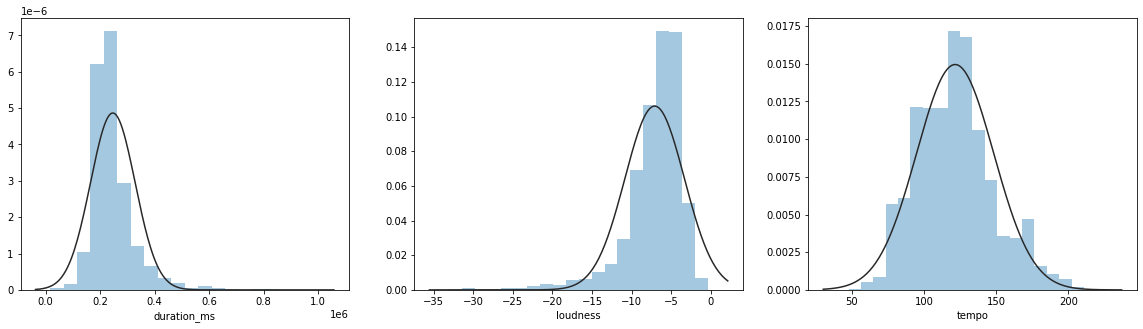

In [60]:
from scipy.stats import norm
fig, axes = plt.subplots(1, 3, figsize=(20,5))

sns.distplot(attributes_spotify_preparation["duration_ms"], fit=norm , kde=False, bins=20, ax=axes[0])
sns.distplot(attributes_spotify_preparation["loudness"], fit=norm , kde=False, bins=20, ax=axes[1])
sns.distplot(attributes_spotify_preparation["tempo"], fit=norm , kde=False, bins=20, ax=axes[2])

A partir de los histogramas observo que las tres variables siguen una distribución aproximadamente normal. La primera con sesgo hacia la izquierda, la segunda con sesgo hacia la derecha y la última bastante centrada. Por este motivo considero que realizar una normalización de los datos (reescalarlos entre 0 y 1) sería perjudicial para el clasificador. Por lo tanto siento conveniente estandarizar todos los atributos, es decir, centrar sus medias en 0 y medir las distancias en términos de desviaciónes estándar. De esta forma tendré todas las variables en una misma escala y será beneficiosos para el clasificador.

Para ello, separemos primero la variable target de los demás atributos en los objetos X e y.

In [61]:
df = attributes_spotify_preparation

X = df.iloc[:,0:-1].values
y = df.iloc[:,-1].values

X, y

(array([[1.02000e-02, 8.33000e-01, 2.04600e+05, ..., 4.31000e-01,
         1.50062e+02, 2.86000e-01],
        [1.99000e-01, 7.43000e-01, 3.26933e+05, ..., 7.94000e-02,
         1.60083e+02, 5.88000e-01],
        [3.44000e-02, 8.38000e-01, 1.85707e+05, ..., 2.89000e-01,
         7.50440e+01, 1.73000e-01],
        ...,
        [8.57000e-03, 6.37000e-01, 2.07200e+05, ..., 1.07000e-01,
         1.50082e+02, 4.70000e-01],
        [1.64000e-03, 5.57000e-01, 1.85600e+05, ..., 1.33000e-01,
         1.50011e+02, 6.23000e-01],
        [2.81000e-03, 4.46000e-01, 2.04520e+05, ..., 1.41000e-01,
         1.90013e+02, 4.02000e-01]]), array([1, 1, 1, ..., 0, 0, 0]))

Ahora realicemos la estandarización sobre nuestros datos X.

In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)

X = scaler.transform(X)

Veamos ahora los histogramas de las variables reescaladas.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

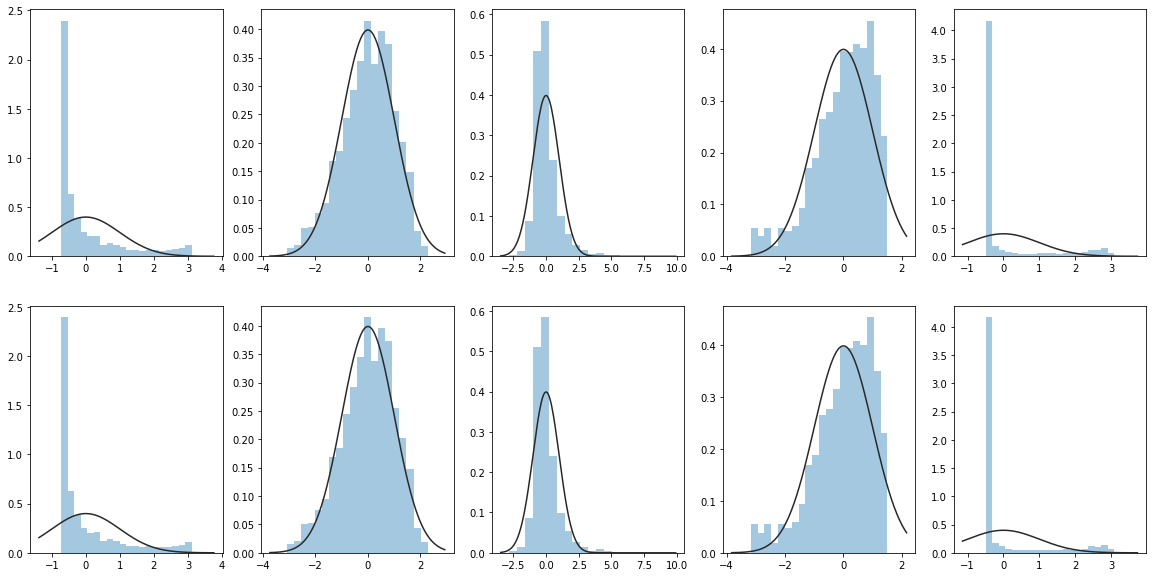

In [63]:
fig, axes = plt.subplots(2, 5, figsize=(20,10))

for i in range(0,5):
  sns.distplot(X[:,i], fit=norm , kde=False, bins=20, ax=axes[0,i])
for i in range(0,5):
  sns.distplot(X[:,i], fit=norm , kde=False, bins=20, ax=axes[1,i])  

Observamos que todas las variables se encuentran en la misma escala y con media igual a cero.

## **Clasificador por K vecinos más cercanos**
Procedamos ahora a entrenar el clasificador de k vecinos más cercanos. Contamos con 2017 datos, por lo que haremos el split entre datos de entrenamiento y validación. Elijo quedarme con el 80% de datos para entrenar (N aproximadamente igual a 1610) y un valor de k = 40 (aprox. raíz cuadrada de N). Luego podemos hacer validación cruzada para entrenar el clasificador con todo el dataset y una búsqueda en función del número de vecinos.

In [64]:
# Separo entre train y validation data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=0)
X_train, y_train

(array([[ 1.03264468, -0.64862745, -0.37448316, ..., -0.73367661,
         -1.72627508,  0.14237196],
        [-0.47817689,  1.73041642,  1.07563691, ...,  1.97238779,
          0.20531995, -1.18484225],
        [ 2.7215947 , -1.08343965, -1.16169433, ..., -0.51345435,
          2.33924649, -0.53742069],
        ...,
        [-0.71563019, -0.12685282,  1.67382028, ..., -0.72811544,
         -0.24732092, -1.81891075],
        [-0.72167351, -1.82262038, -1.66874954, ..., -0.24095712,
         -0.97703376, -1.26576995],
        [-0.61360068,  0.1340345 , -0.60011352, ...,  0.84903183,
         -1.26216452,  0.67649475]]), array([1, 1, 1, ..., 0, 1, 1]))

In [65]:
# Entreno el clasificador
from sklearn import neighbors

k_vecinos = 40  # Número de vecino a considerar (Elijo sqrt(N))

knn = neighbors.KNeighborsClassifier(n_neighbors=k_vecinos) #Por ahora utilizo estos valores. Luego puedo hacer un grid search.
knn.fit(X_train,y_train)

# Calculo las predicciones con los datos que guardé para validar
y_pred = knn.predict(X_test)

In [66]:
# Calculo los parámetros de evaluación
from sklearn import metrics

accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
f_measure = metrics.f1_score(y_test, y_pred)

In [67]:
from tabulate import tabulate

tabla = [['KNN Classifier', 'N = 80% and k 40'],
         ['Exactitud', round(accuracy,2)],
         ['Precisión', round(precision,2)],
         ['f-measure', round(f_measure,2)]]
        
print(tabulate(tabla,
               tablefmt='fancy_grid',
               stralign='center'))

╒════════════════╤══════════════════╕
│ KNN Classifier │ N = 80% and k 40 │
├────────────────┼──────────────────┤
│   Exactitud    │       0.69       │
├────────────────┼──────────────────┤
│   Precisión    │       0.77       │
├────────────────┼──────────────────┤
│   f-measure    │       0.64       │
╘════════════════╧══════════════════╛


Los parámetros de evaluación que obtengo no son lo suficientemente altos para conformarme. Observemos la matriz de confusión para analizar el por qué de estos valores.

Text(0.5, 0.98, 'Matriz de confusión')

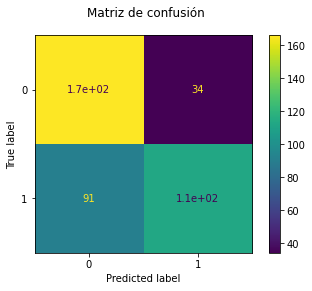

In [68]:
disp = metrics.plot_confusion_matrix(knn, X_test, y_test)
disp.figure_.suptitle("Matriz de confusión")

De esta matriz observo que obtengo muchísimos falsos negativos. Esto quiere decir que el clasificador está interpretando muchas canciones que le gustan al usuario como no gustadas. Ahora me hago la pregunta de si esto es relevante en el clasificador que estoy entrenando. Porque si el propósito de este clasificador es ser usado para luego sugerirle nuevas canciones al usuario, que interpreta que le van a gustar, lo importante del clasificador sería que tenga muy poca cantidad de falsos positivos. Y eso lo estoy logrando, ya que obtengo solamente 34 falsos positivos contra 110 verdaderos positivos. Bajo esta interpretación, que obtenga un número alto de falsos negativos no sería tan relevante, porque simplemente el fallo sería dejarle de sugerir ciertas canciones al usuario que le podrían haber llegado a gustar. Por este motivo, la métrica que más me interesa sería la precisión del modelo, y para ésta obtengo un valor medianamente alto de 77%, lo que me resulta aceptable.

De todas formas, realicemos una validación cruzada y un posterior análisis en función del número de vecinos para ver si podemos subir estos parámetros.

## **Validación Cruzada**

In [69]:
from sklearn.model_selection import KFold

# Mi dataset cuenta con 2017 datos. Elijo 5 splits, por lo que estoy eligiendo aproximadamente 1600 datos para entrenar (80%) y 400 para testear en cada iteración.
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Entrenemos el clasificador para cada split y calculemos los parámetros de evaluación
k_vecinos = 40  # Número de vecino a considerar
knn = neighbors.KNeighborsClassifier(n_neighbors=k_vecinos)


average_precision = 0
average_accuracy = 0
i = 1
for train_index, test_index in kf.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  knn.fit(X_train,y_train)
  y_pred = knn.predict(X_test)

  accuracy = metrics.accuracy_score(y_test, y_pred)
  precision = metrics.precision_score(y_test, y_pred)
  f_measure = metrics.f1_score(y_test, y_pred)

  average_precision += precision
  average_accuracy += accuracy

  print('Fold {}: '.format(i), 'exactitud = ', round(accuracy, 2), 'precision = ', round(precision, 2), 'f_measure = ', round(f_measure, 2))

  i += 1

average_precision = average_precision/5
average_accuracy = average_accuracy/5
print('average precision = ', round(average_precision, 2))
print('average accuracy = ', round(average_accuracy, 2))

Fold 1:  exactitud =  0.73 precision =  0.83 f_measure =  0.67
Fold 2:  exactitud =  0.73 precision =  0.84 f_measure =  0.7
Fold 3:  exactitud =  0.71 precision =  0.81 f_measure =  0.67
Fold 4:  exactitud =  0.68 precision =  0.78 f_measure =  0.64
Fold 5:  exactitud =  0.69 precision =  0.75 f_measure =  0.61
average precision =  0.8
average accuracy =  0.71


Podemos observar que el 'Fold 2' arroja los mejores valores de las métricas, obteniendo un 84% de precisión para el modelo. Además, obtengo un 10% de diferencia entre el Fold que maximiza la precisión y el que la minimiza arrojando una precisión promedio entre las 5 particiones de 80%, lo que considero un valor bastante aceptable. La exactitud promedio es de un 71%, lo que me está diciendo que el modelo predecirá correctamente 7 de 10 datos nuevos que nunca haya visto.

Evaluemos ahora en función del número de vecinos para ver cuál sería el mejor valor a utilizar.

In [70]:
# Entreno el clasificador para k entre 10 y 100, recordando que antes utilicé k = 40.

k_vecinos = []
for k in range(10,100):
  k_vecinos.append(k)

average_precision = []

for k in k_vecinos:

  knn = neighbors.KNeighborsClassifier(n_neighbors=k)
  precision = []
  
  for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)

    precision.append(metrics.precision_score(y_test, y_pred))

  average_precision.append(np.array(precision).mean())

Text(0, 0.5, 'Cross-Validated Average Precision')

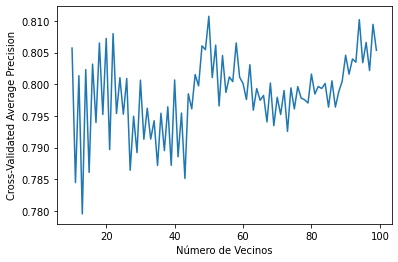

In [71]:
plt.plot(k_vecinos,average_precision)
plt.xlabel('Número de Vecinos')
plt.ylabel('Cross-Validated Average Precision')

Del gráfico veo bastante ruido pero entre 40 y 60 obtengo un máximo para la precisión promedio utilizando validación cruzada con un 80% de train data. Veamos en qué valor se obtiene el máximo.

In [72]:
max_average_precision = np.amax(average_precision)
print('Precisión Promedio Máxima = ', round(max_average_precision,2))

k_vecinos_maximo = np.where(average_precision == max_average_precision)
print('Para k vecinos = ', k_vecinos_maximo[0] + 10)

Precisión Promedio Máxima =  0.81
Para k vecinos =  [50]


Finalmente observo que la precisión promedio máxima es de 81% considerando 50 vecinos.